### Importing The necessary Libraries

In [2]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image_dataset_from_directory
import sklearn.metrics as metrics
import tensorflow as tf  
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization,MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling3D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy

from PIL import Image
import os
import os.path
from scipy import ndimage
import cv2
import numpy as np


Below, we can see a few examples of the images in the the dataset
OpenCV represents the images in BGR as opposed to the RGB we expect. Since it is in the reverse order, I convert BGR to RGB to show the right colors.

Text(0.5, 1.0, 'Sample 4')

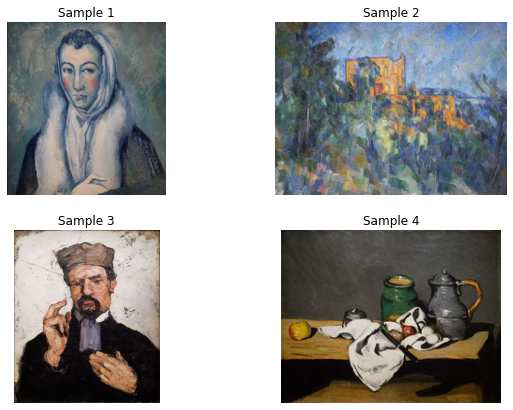

In [2]:
# create figure
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
rows = 2
columns = 2
# reading images and converting BGR to RGB,
Image1 = cv2.imread('sample1.jpg')[:,:,::-1]
Image2 = cv2.imread('sample2.jpg')[:,:,::-1]
Image3 = cv2.imread('sample3.jpg')[:,:,::-1]
Image4 = cv2.imread('sample4.jpg')[:,:,::-1]
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Sample 1")
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Sample 2")
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Sample 3")
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Sample 4")

If the machine detects a GPU it will run the program on it, if not it will proceed to run the program on CPU.

In [3]:
#Check if tensorflow is running on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU found. TF is now running on GPU")
else:
    print("No GPU device found")

GPU found. TF is now running on GPU


### Data Preprocessing

Below I apply data augmentations like shifting, zooming, rotating, etc on the training set. I keep the original RGB colors.

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    zoom_range=0.1
)
training_set = train_datagen.flow_from_directory(
    r"C:\Users\mojan\Desktop\Dataset_Final\Random Cropping\120-256\training_set",
    seed = 123,
    target_size = (256,256),
    color_mode="rgb",
    batch_size = 10,
    class_mode = "binary"
)

Found 10500 images belonging to 2 classes.


I keep the validation set intact and do not apply any data augmentation on it.(except for rescaling)

In [6]:
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)
validation_set = validation_datagen.flow_from_directory(
    r"C:\Users\mojan\Desktop\Dataset_Final\Random Cropping\120-256\validation_set",
    target_size = (256, 256),
    batch_size = 10,
    color_mode="rgb",
    seed  = 123,
    class_mode = "binary"
)

Found 4500 images belonging to 2 classes.


### Importing The Pretrained Model from Keras

Below I import the VGG16 pretrained model from the keras library, I dispose of the original top fully connected layers and add a dropout layer, a dense layer of 256 and a final binary dense on top of the original convolutional layers.

In [7]:
import numpy as np
from keras import regularizers
from keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
#importing pretrained models
from tensorflow.keras.applications import (
    resnet50,
    vgg16
)
pretrained_model = vgg16.VGG16(
    weights="imagenet",
    include_top = False,
    pooling = "max",
    input_shape = (256, 256,3) #our image dimensions with 3 color channels kept intact
)

#Setting the status of the imported convolutional layers as untrainable for now
pretrained_model.trainable=False   

# construct the head of the model that will be placed on top of the base model
headModel = pretrained_model.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
model = Model(inputs=pretrained_model.input, outputs=headModel)
    

Below we can see a summary of the model.

In [8]:
for i, layers in enumerate(model.layers):
    print(i, layers.name)
    

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_max_pooling2d
20 flatten
21 dropout
22 dense
23 dense_1


In [9]:
for index, layer in enumerate(model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: False
Layer: 1, Trainable: False
Layer: 2, Trainable: False
Layer: 3, Trainable: False
Layer: 4, Trainable: False
Layer: 5, Trainable: False
Layer: 6, Trainable: False
Layer: 7, Trainable: False
Layer: 8, Trainable: False
Layer: 9, Trainable: False
Layer: 10, Trainable: False
Layer: 11, Trainable: False
Layer: 12, Trainable: False
Layer: 13, Trainable: False
Layer: 14, Trainable: False
Layer: 15, Trainable: False
Layer: 16, Trainable: False
Layer: 17, Trainable: False
Layer: 18, Trainable: False
Layer: 19, Trainable: False
Layer: 20, Trainable: True
Layer: 21, Trainable: True
Layer: 22, Trainable: True
Layer: 23, Trainable: True


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [17]:
#our two classes
print(training_set.class_indices)
print(validation_set.class_indices)

{'cezanne': 0, 'others': 1}
{'cezanne': 0, 'others': 1}


### Compiling and Fitting the Model

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss = "binary_crossentropy",
    metrics =["accuracy"]
)

In [20]:
batch_size = 10
epochs = 20
history = model.fit(
training_set,
validation_data = validation_set,
epochs = epochs
)

Epoch 1/20
1050/1050 [==============================] - 178s 161ms/step - loss: 0.7146 - accuracy: 0.5284 - val_loss: 0.6800 - val_accuracy: 0.5591
Epoch 2/20
1050/1050 [==============================] - 172s 164ms/step - loss: 0.6831 - accuracy: 0.5684 - val_loss: 0.6665 - val_accuracy: 0.5789
Epoch 3/20
1050/1050 [==============================] - 168s 160ms/step - loss: 0.6720 - accuracy: 0.5846 - val_loss: 0.6538 - val_accuracy: 0.6013
Epoch 4/20
1050/1050 [==============================] - 167s 159ms/step - loss: 0.6599 - accuracy: 0.6011 - val_loss: 0.6326 - val_accuracy: 0.6373
Epoch 5/20
1050/1050 [==============================] - 168s 160ms/step - loss: 0.6488 - accuracy: 0.6175 - val_loss: 0.6304 - val_accuracy: 0.6407
Epoch 6/20
1050/1050 [==============================] - 163s 155ms/step - loss: 0.6425 - accuracy: 0.6240 - val_loss: 0.6299 - val_accuracy: 0.6380
Epoch 7/20
1050/1050 [==============================] - 178s 169ms/step - loss: 0.6432 - accuracy: 0.6253 - val_

In [22]:
model.save('my_final_model_transfer.h5')

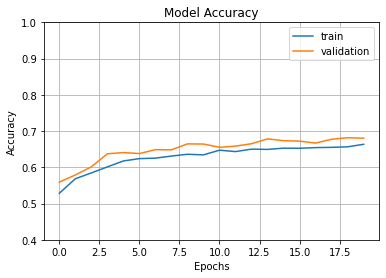

In [23]:
##visualizing accuracy rates for train and validation set
fig1 = plt.gcf()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis(ymin = 0.4, ymax =1)
plt.grid()
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

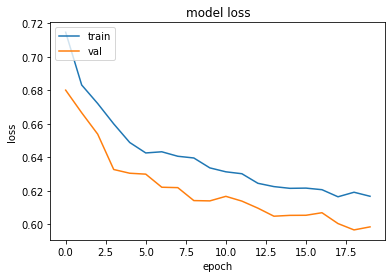

In [24]:
#visualizing loss rates for train and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Trainging the fully connected layer only(transfer learning) did not lead to good results. This could be because VGG16 pretrained network can classify images into 1000 object categories, such as keyboard,  mouse, pencil, and many animals and was not trained for art-related purposes. So here I am going to try fine-tuning different convolutional layers to train more parameters to see how that affects the result.

It is critical to only do the fine-tuning step after the model with frozen convolutional layers has been trained to convergence once. If I mix randomly-initialized trainable layers with trainable layers that hold pre-trained features, the randomly-initialized layers will cause very large gradient updates during training, which will destroy the pre-trained features.

In [10]:
loaded_model = keras.models.load_model('my_final_model_transfer.h5')

In [12]:
#fine-tuning all of the layers in the model
#I have 14,846,273 trainable parameters now
for layer in loaded_model.layers[0:]:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True
  

In [13]:
for index, layer in enumerate(loaded_model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: True
Layer: 1, Trainable: True
Layer: 2, Trainable: True
Layer: 3, Trainable: True
Layer: 4, Trainable: True
Layer: 5, Trainable: True
Layer: 6, Trainable: True
Layer: 7, Trainable: True
Layer: 8, Trainable: True
Layer: 9, Trainable: True
Layer: 10, Trainable: True
Layer: 11, Trainable: True
Layer: 12, Trainable: True
Layer: 13, Trainable: True
Layer: 14, Trainable: True
Layer: 15, Trainable: True
Layer: 16, Trainable: True
Layer: 17, Trainable: True
Layer: 18, Trainable: True
Layer: 19, Trainable: True
Layer: 20, Trainable: True
Layer: 21, Trainable: True
Layer: 22, Trainable: True
Layer: 23, Trainable: True


In [14]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [15]:
loaded_model.compile(
    optimizer=Adam(learning_rate=0.00001), 
    loss = "binary_crossentropy",
    metrics =["accuracy"]
)

In [16]:
epochs = 20
history = loaded_model.fit(
training_set,
validation_data = validation_set,
epochs = epochs,
#steps_per_epoch = np.math.ceil(97/8)   
)

Epoch 1/20
1050/1050 [==============================] - 191s 172ms/step - loss: 0.5288 - accuracy: 0.7305 - val_loss: 0.4395 - val_accuracy: 0.7947
Epoch 2/20
1050/1050 [==============================] - 182s 174ms/step - loss: 0.3661 - accuracy: 0.8356 - val_loss: 0.2465 - val_accuracy: 0.9011
Epoch 3/20
1050/1050 [==============================] - 184s 175ms/step - loss: 0.2534 - accuracy: 0.8957 - val_loss: 0.1508 - val_accuracy: 0.9418
Epoch 4/20
1050/1050 [==============================] - 186s 177ms/step - loss: 0.1819 - accuracy: 0.9221 - val_loss: 0.1226 - val_accuracy: 0.9520
Epoch 5/20
1050/1050 [==============================] - 185s 176ms/step - loss: 0.1479 - accuracy: 0.9420 - val_loss: 0.1758 - val_accuracy: 0.9311
Epoch 6/20
1050/1050 [==============================] - 185s 176ms/step - loss: 0.1235 - accuracy: 0.9509 - val_loss: 0.0818 - val_accuracy: 0.9718
Epoch 7/20
1050/1050 [==============================] - 185s 177ms/step - loss: 0.0912 - accuracy: 0.9664 - val_

In [17]:
loaded_model.save('my_final_model_tuned_entirely.h5')

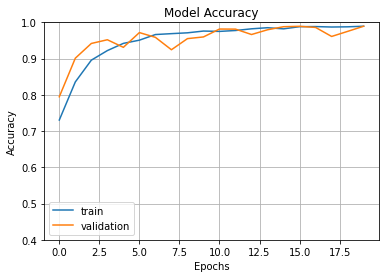

In [18]:
#visualizing accuracy rates for train and validation set
fig1 = plt.gcf()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.axis(ymin = 0.4, ymax =1)
plt.grid()
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

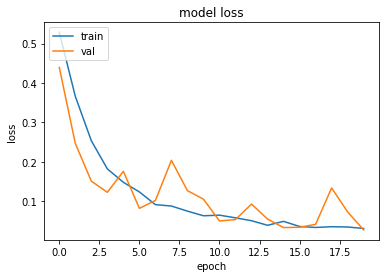

In [19]:
#visualizing loss rates for train and validation set
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Confusion Matrix of the final model

In [3]:
#There are two unseen paintings in the predict_set
predict_datagen = ImageDataGenerator(
    rescale = 1./255
)
predict_set = predict_datagen.flow_from_directory(
    r"C:\Users\mojan\Desktop\Dataset_Final\Random Cropping\120-256\predict_set",
    target_size = (256, 256),
    batch_size = 10,
    color_mode="rgb",
    shuffle=False,
    class_mode = "binary"
)

Found 10 images belonging to 2 classes.


In [17]:
# assessing precision, recall and f1_score for the prediction set
batch_size=10
test_steps_per_epoch = np.math.ceil(len(predict_set)/batch_size)
predict_model = keras.models.load_model(
    "my_final_model_tuned_entirely.h5"
)

predictions = predict_model.predict_generator(predict_set, steps=test_steps_per_epoch, verbose =1)
# Get most likely class
predicted_classes = np.round(predictions)
true_classes = predict_set.classes
class_labels = list(predict_set.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

1/1 [==============================] - ETA: 0s

C:\Users\mojan\anaconda3\envs\CNN\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


1/1 [==============================] - 0s 156ms/step
              precision    recall  f1-score   support

     cezanne       1.00      0.75      0.86         4
      others       0.86      1.00      0.92         6

    accuracy                           0.90        10
   macro avg       0.93      0.88      0.89        10
weighted avg       0.91      0.90      0.90        10



In [11]:
#getting true labes and the predicted labels
y_true = predict_set.classes
print(y_true)
y_pred = predictions > 0.5
y_pred = ((y_pred)*1).flatten()
print(y_pred)

[0 0 0 0 1 1 1 1 1 1]
[0 0 1 0 1 1 1 1 1 1]


In [12]:
tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

array([[3, 1],
       [0, 6]])

In [13]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3 1]
 [0 6]]


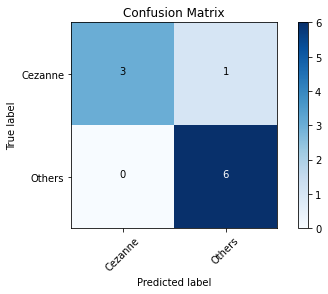

In [14]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cm_plot_labels = ['Cezanne','Others']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Testing the model on each painting from the prediction set individually

Painted by others
tf.Tensor(0.9471874, shape=(), dtype=float32)


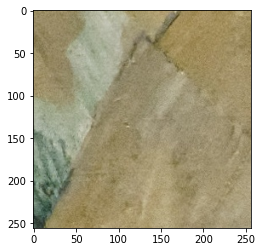

In [18]:
import numpy as np 
from keras.preprocessing import image

im = cv2.imread(r"C:\Users\mojan\Desktop\Dataset_Final\Random Cropping\120-256\predict_set\others\17_braque_chtchoukine_27.jpg")[:,:,::-1]
plt.imshow(im)



test_image = image.load_img(
    r"C:\Users\mojan\Desktop\Dataset_Final\Random Cropping\120-256\predict_set\others\17_braque_chtchoukine_27.jpg"
    , target_size = (256, 256)
)


test_image = np.expand_dims(test_image, axis=0)
test_image = np.asarray(test_image)/255
pred = predict_model(test_image)
# training_set.class_indices;
if pred[0][0] < 0.5:
    prediction = "Painted by Cezanne"
else:
    prediction = "Painted by others"
# print(prediction)
print(prediction)
print(pred[0][0])